# Create a basic optimization model

In this example, we explain the basic functions of the linopy Model class. First, we are setting up a very simple linear optimization model, given by 

     Minimize:
$$ x + 2y $$
      
     subject to:
$$ x \ge 0 $$
$$y \ge 0 $$
$$3x + 7y \ge 10 $$
$$5x + 2y \ge 3 $$


In [1]:
from linopy import Model

In [2]:
m = Model()

The Model class serves at a container for all the relevant data. 

### Adding variables

Let's add the two variables. Note that a variable can always be assigned with a lower and an upper bound. In this case, both `x` and `y` have a lower bound of zero (coming from the first two constraints). Note, the default for lower and upper bounds are minus and plus infinity.

In [3]:
x = m.add_variables(lower=0, name='x')
y = m.add_variables(lower=0, name='y');

`x` and `y` are linopy variables. Each of them consist of an array with the variable references in the model, that is the names of variables that will finally be used when solving the model. 

In [4]:
x

Variable container:
-------------------

Variables:
array(0)
Attributes:
    name:     x

Since both `x` and `y` are scalar variables, so their arrays also contain just one variable reference. The variable `x` points to the optimisation variable 1 and the variable `y` points to the optimisation variable 2. Later we will see the benefit of this behaviour.  

### Adding Constraints

Constraints consist of the left hand side (lhs) and the righ hand side (rhs). The lhs must contain all the variables with the corresponding coefficients, while the rhs is just constant. The first lhs of our two remaining constraints is 
$3x + 7y$, which we can write just exactly in this way

In [5]:
3*x + 7*y

Linear Expression with 2 term(s):
----------------------------------

Dimensions:  (_term: 2)
Coordinates:
  * _term    (_term) int64 0 1
Data:
    coeffs   (_term) int64 3 7
    vars     (_term) int64 0 1

When assigning to the model, we call the function `m.add_constraints`.

In [6]:
m.add_constraints(3*x + 7*y, '>=', 10)
m.add_constraints(5*x + 2*y, '>=', 3);

## Adding the Objective 

We do the same for defining the objective while the objective function only consists of a linear expression.

In [7]:
m.add_objective(x + 2*y)

Linear Expression with 2 term(s):
----------------------------------

Dimensions:  (_term: 2)
Coordinates:
  * _term    (_term) int64 0 1
Data:
    coeffs   (_term) int64 1 2
    vars     (_term) int64 0 1

In [9]:
m.solve(solver_name='cbc')

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Dec  8 2020 

command line - cbc -printingOptions all -import /tmp/linopy-problem-1me13f94.lp -solve -solu /tmp/linopy-solve-78uq58ut.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 2 (0) rows, 2 (0) columns and 4 (0) elements
0  Obj 0 Primal inf 2.0285712 (2)
2  Obj 2.862069
Optimal - objective value 2.862069
Optimal objective 2.862068966 - 2 iterations time 0.002
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



Linopy model

Variables:
----------
Dimensions:  ()
Data:
    x        int64 0
    y        int64 1

Constraints:
------------
Dimensions:  ()
Data:
    con0     int64 0
    con1     int64 1

Status:
-------
optimal

The solution of the linear problem is stored in `m.solution` in fom of a `xarray.Dataset`. 

In [10]:
m.solution

<xarray.Dataset>
Dimensions:  ()
Data variables:
    x        float64 0.03448
    y        float64 1.414

## Expanding the dimensionality

Now comes the interesting part. Suppose the two variables `x` and `y` are a function of time `t` and a modified problem setup like 

Minimize:
$$\sum_t x_t + 2 y_t$$
subject to:
$$
x_t \ge 0 \qquad \forall t \\
y_t \ge 0 \qquad \forall t \\
3x_t + 7y_t \ge 10 t \qquad \forall t\\
5x_t + 2y_t \ge 3 t \qquad \forall t
$$
whereas `t` spans all the range from 0 to 10.

First, we define a new model (we just overwrite the old `m`).

In [11]:
m = Model()

Again, we define `x` and `y` using the `add_variables` function, but now we are adding a `coords` argument. This automatically creates optimization variables for all coordinates, in this case time-steps.

In [12]:
import pandas as pd
time = pd.Index(range(10), name='time')

x = m.add_variables(lower=0, coords=[time], name='x', )
y = m.add_variables(lower=0, coords=[time], name='y')

We again write the constraints out using the syntax from above, while multiplying the rhs with `t`. Note that the coordinates from the lhs and the rhs have to match. 

*Note: In case lhs and rhs have different sets of coordinates, the constraint creation is broadcasted over all combinations of coordinates.*

In [13]:
factor = pd.Series(time, index=time)

m.add_constraints(3*x + 7*y, '>=', 10*factor, name='Constraint1')
m.add_constraints(5*x + 2*y, '>=', 3*factor, name='Constraint2')
m

Linopy model

Variables:
----------
Dimensions:  (time: 10)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Data:
    x        (time) int64 0 1 2 3 4 5 6 7 8 9
    y        (time) int64 10 11 12 13 14 15 16 17 18 19

Constraints:
------------
Dimensions:      (time: 10)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9
Data:
    Constraint1  (time) int64 0 1 2 3 4 5 6 7 8 9
    Constraint2  (time) int64 10 11 12 13 14 15 16 17 18 19

Status:
-------
initialized

When we add the objective, we use the `sum` function of `linopy.LinearExpression`. This stacks the `term_` dimension, such that all terms of the `time` dimension are rewritten into one big expression. 

In [14]:
obj = (x + 2*y).sum()
m.add_objective(obj)

Linear Expression with 20 term(s):
----------------------------------

Dimensions:  (_term: 20)
Coordinates:
  * _term    (_term) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data:
    coeffs   (_term) int64 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
    vars     (_term) int64 0 10 1 11 2 12 3 13 4 14 5 15 6 16 7 17 8 18 9 19

In [17]:
m.solve(solver_name='cbc');

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Dec  8 2020 

command line - cbc -printingOptions all -import /tmp/linopy-problem-gjp3a6l3.lp -solve -solu /tmp/linopy-solve-74_0vmuc.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 18 (-2) rows, 18 (-2) columns and 36 (-4) elements
Perturbing problem by 0.001% of 2 - largest nonzero change 5.4674472e-05 ( 0.0051635596%) - largest zero change 0
0  Obj 0 Primal inf 91.285696 (18)
18  Obj 128.79618
Optimal - objective value 128.7931
After Postsolve, objective 128.7931, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 128.7931034 - 18 iterations time 0.002, Presolve 0.00
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.00



<AxesSubplot:xlabel='time', ylabel='Optimal Value'>

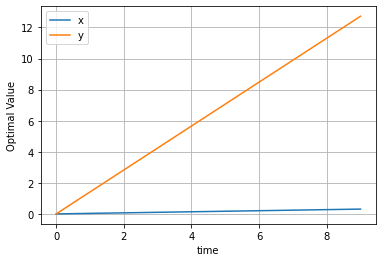

In [18]:
m.solution.to_dataframe().plot(grid=True, ylabel='Optimal Value')

You can easily add dimensions in this way. Since the underlying code is highly relying on `xarray` broadcasting on new dimensions is automatically supported, so even the `rhs` can introduce new dimensions. Just be carefull that all variable dimensions have the correct dimension name. 

We limit the slope of the `y` variable by adding a constraint in the form of 
$$ y_{t} - y_{t-1} \le 0.5 \qquad \forall t \ge 1$$

In [19]:
lhs = (y - y.shift(time=1)).sel(time=time[1:])
m.add_constraints(lhs, '<=', 0.5, name='Limited growth y')

<xarray.DataArray (time: 9)>
array([20, 21, 22, 23, 24, 25, 26, 27, 28])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9
Attributes:
    name:     Limited growth y

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Dec  8 2020 

command line - cbc -printingOptions all -import /tmp/linopy-problem-i7hvv1nk.lp -solve -solu /tmp/linopy-solve-y4y26sce.sol  (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 27 (-2) rows, 19 (-1) columns and 54 (-4) elements
Perturbing problem by 0.001% of 2 - largest nonzero change 0.00022498367 ( 0.011249183%) - largest zero change 0
0  Obj 0 Primal inf 91.285696 (18)
19  Obj 141.59453
Optimal - objective value 141.58621
After Postsolve, objective 141.58621, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 141.5862069 - 19 iterations time 0.002, Presolve 0.00
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00



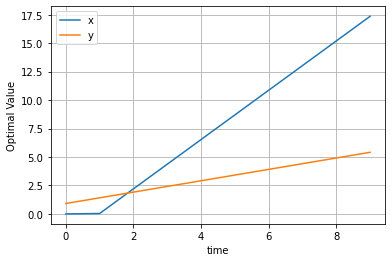

In [21]:
m.solve(solver_name='cbc')
m.solution.to_dataframe().plot(grid=True, ylabel='Optimal Value');